# Collaborative Filtering for Movie Rating Predictions

Given a matrix of user-item ratings of movies, the following code will output a numerical prediction indicating a prediction of a user's rating for a movie and a top list of recommended movies that are computed using the similarity between items/movies. The dataset will be split into a training and test dataset whiich will be evaluated with both the item-based and user-based collaborative filitering method The predictions will be evaluated using root-mean-square error (RMSE). 

In [554]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from scipy import sparse
from random import sample
import math

In [472]:
ratings = pd.read_csv('data/ratings.csv')
movies = pd.read_csv('data/movies.csv')

In [473]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [474]:
ratings = ratings.drop(columns=['timestamp'])

In [475]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


## Data Pre-Processing

Text(0, 0.5, 'Number of Movies')

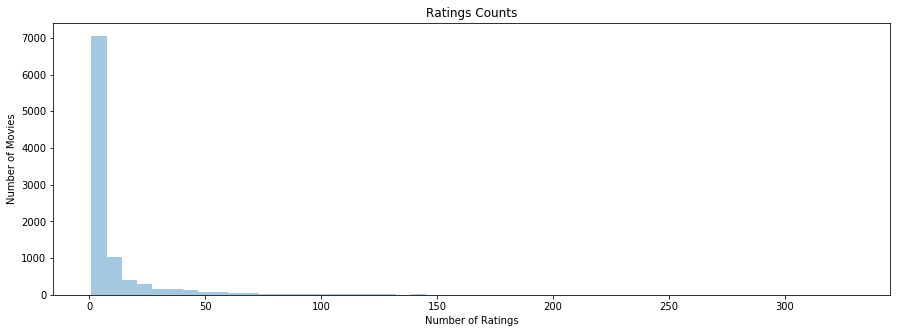

In [477]:
ratings_mean = pd.DataFrame(ratings.groupby('movieId')['rating'].mean())
ratings_mean['count'] = pd.DataFrame(ratings.groupby('movieId')['rating'].count())


# Plotting
fig, ax = plt.subplots(figsize=(15,5))
counts = ratings_mean['count']
sns.distplot(counts, kde=False, ax=ax)
ax.grid(False)
ax.set_title("Ratings Counts")
ax.set_xlabel("Number of Ratings")
ax.set_ylabel("Number of Movies")

Text(45.125, 0.5, 'Mean Rating')

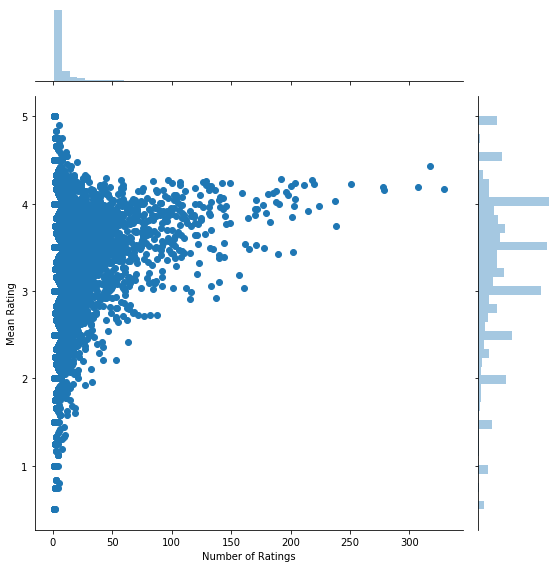

In [478]:
joint_plot = sns.jointplot(x = 'count',
                          y = 'rating',
                          data = ratings_mean,
                           height = 8,
                          )
joint_plot.ax_joint.set_xlabel("Number of Ratings")
joint_plot.ax_joint.set_ylabel("Mean Rating")

As we can see from the classic long tail property, there are a number of movies that do not have many ratings. Thus, we will drop these movies that are irrelevant with little data based on a count threshold. Interestingly, movies with more ratings and are more popular seemed be rated fairly similarly with an average rating of 4 whereas movies with very few ratings were heavily biased towards extreme values of 0-5.

In [527]:
# Transform the ratings table using movies as unique rows and users as unique columns with rating values
movie_ratings = ratings.pivot_table('rating', index='movieId', columns='userId')
movie_ratings

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,NaN,NaN,4.0,NaN,4.5,NaN,NaN,NaN,...,4.0,NaN,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,NaN,NaN,NaN,NaN,NaN,4.0,NaN,4.0,NaN,NaN,...,NaN,4.0,NaN,5.0,3.5,NaN,NaN,2.0,NaN,NaN
3,4.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193581,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193583,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193585,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [528]:
# Dropping movies that have less than threshold amount of ratings
COUNT_THRESHOLD = 10
movie_ratings['count'] = movie_ratings.count(axis='columns')
movie_ratings = movie_ratings[movie_ratings['count'] >= 10]
movie_ratings.drop(['count'], axis = 1, inplace = True)
movie_ratings = movie_ratings.fillna(0)
movie_ratings = movie_ratings.reset_index()
movie_ratings = movie_ratings.rename(columns = {'userId': 'movie_index'})
movie_ratings = movie_ratings.rename_axis(None, axis=1).rename_axis('movie_index', axis=0)
movie_ratings

/Users/jasonyan/Library/Python/3.7/lib/python/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,movieId,1,2,3,4,5,6,7,8,9,...,601,602,603,604,605,606,607,608,609,610
movie_index,,,,,,,,,,,,,,,,,,,,,
0,1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
1,2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
2,3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
3,5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
4,6,4.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,3.0,4.0,3.0,0.0,0.0,0.0,0.0,0.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2264,174055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2265,176371,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2266,177765,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [529]:
movie_ratings.at[2264, 601]

4.0

In [530]:
# Movie information lookup table
movies_df = movie_ratings.drop(movie_ratings.columns.difference(['movieId']), 1, inplace=False)
movies_df.reset_index(inplace=True)
movies_df = pd.merge(movies_df, movies, on ='movieId')
movies_df

,movie_index,movieId,title,genres
0,0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,2,Jumanji (1995),Adventure|Children|Fantasy
2,2,3,Grumpier Old Men (1995),Comedy|Romance
3,3,5,Father of the Bride Part II (1995),Comedy
4,4,6,Heat (1995),Action|Crime|Thriller
...,...,...,...,...
2264,2264,174055,Dunkirk (2017),Action|Drama|Thriller|War
2265,2265,176371,Blade Runner 2049 (2017),Sci-Fi
2266,2266,177765,Coco (2017),Adventure|Animation|Children
2267,2267,179819,Star Wars: The Last Jedi (2017),Action|Adventure|Fantasy|Sci-Fi


In [531]:
# Randomly chooses 5 ratings per user to be used for testing
# Returns the ratings dataframe with the replaced values as zero
# Returns the test dataframe and actual dataframe
def train_test_split(df):
    train = df.copy()
    column_names = ['userId', 'movieId', 'rating']
    actual_df = pd.DataFrame(columns = column_names)
    
    # content - pandas series of all the ratings given by a user for every movie
    for userId, content in train.items():
        if type(userId) == int:
            #print(userId)
            #print(content)
            
            # Get the movie indexes that will be tested on
            rated = content.nonzero()
            test_indexes = np.random.choice(rated[0], size=5, replace=False)
            #print(test_indexes)
            
            for movieIndex in test_indexes:
                # Store userId, movieId, rating in actual dataframe
                rating = content.get(key = movieIndex)
                movieId = movieIndex_to_movieId(movies_df, movieIndex)
                row = [userId, movieId, rating]
                actual_df.loc[len(actual_df)] = row
                
                # Replace the userId-movieId value with zero in the ratings dataframe
                train.at[movieIndex, userId] = 0.0

    test_df = actual_df.drop(['rating'], axis = 1)
    print(actual_df)
    
    return train, test_df, actual_df
            
movie_ratings, test_ratings, actual_ratings = train_test_split(movie_ratings)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  app.launch_new_instance()


      userId  movieId  rating
0        1.0   1573.0     5.0
1        1.0   1805.0     4.0
2        1.0   1210.0     5.0
3        1.0   3617.0     4.0
4        1.0   1097.0     5.0
...      ...      ...     ...
3045   610.0   1953.0     5.0
3046   610.0   8366.0     4.0
3047   610.0   6283.0     4.5
3048   610.0   3911.0     4.5
3049   610.0   4247.0     3.0

[3050 rows x 3 columns]


In [532]:
# User ratings table to compute user-based similarities
# Transposed matrix of movie_ratings
user_ratings = movie_ratings.T[1:]
user_ratings.index.name = 'userId'
user_ratings

movie_index,0,1,2,3,4,5,6,7,8,9,...,2259,2260,2261,2262,2263,2264,2265,2266,2267,2268
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,0.0,0.0,0.0,0.0,2.5,0.0,0.0,2.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
607,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
608,2.5,2.0,2.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [533]:
def movieIndex_to_movieId(movies_df, movieIndex):
    movieId = movies_df.loc[movies_df['movie_index'] == movieIndex, 'movieId'].iloc[0]
    return movieId

In [534]:
def movieId_to_movieIndex(movies_df, movieId):
    movieIndex = movies_df.loc[movies_df['movieId'] == movieId, 'movie_index'].iloc[0]
    return movieIndex

In [535]:
def movieId_to_title(movies_df, movieId):
    title = movies_df.loc[movies_df['movieId'] == movieId, 'title'].iloc[0]
    return title

In [536]:
# Total amount of non-zero ratings in the dataset
user_counts = (user_ratings != 0).astype(int).sum(axis=1)
user_counts.sum()

78066

## Pair-Wise Item Similarities

In [537]:
def get_similarities(df):
    similarities = cosine_similarity(df)
    similarities_df = pd.DataFrame(similarities)
    return similarities_df

In [538]:
similarities_item = get_similarities(movie_ratings)
similarities_user = get_similarities(user_ratings)
similarities_user

,0,1,2,3,4,5,6,7,8,9,...,600,601,602,603,604,605,606,607,608,609
0,1.000000,0.033875,0.120636,0.226541,0.115070,0.143653,0.169839,0.132483,0.067221,0.021017,...,0.090804,0.183898,0.289983,0.075976,0.167296,0.218710,0.283513,0.313681,0.099974,0.183996
1,0.033875,1.000000,0.000000,0.004812,0.020684,0.014685,0.034188,0.034504,0.000000,0.090772,...,0.183932,0.020902,0.018336,0.000000,0.000000,0.044207,0.016183,0.056911,0.043179,0.128307
2,0.120636,0.000000,1.000000,0.005217,0.000000,0.006686,0.000000,0.000000,0.000000,0.000000,...,0.005029,0.004079,0.042451,0.000000,0.026059,0.022760,0.006316,0.026966,0.000000,0.044920
3,0.226541,0.004812,0.005217,1.000000,0.145297,0.102322,0.133912,0.058003,0.016323,0.040371,...,0.091349,0.144619,0.384556,0.056467,0.103645,0.260691,0.141145,0.166273,0.047338,0.140482
4,0.115070,0.020684,0.000000,0.145297,1.000000,0.329098,0.102713,0.283650,0.000000,0.038226,...,0.031372,0.393995,0.133274,0.263599,0.167817,0.126669,0.141507,0.120442,0.336309,0.068763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,0.218710,0.044207,0.022760,0.260691,0.126669,0.143954,0.265198,0.124972,0.089974,0.121578,...,0.240632,0.154836,0.433424,0.089284,0.206851,1.000000,0.201428,0.358687,0.100223,0.321250
606,0.283513,0.016183,0.006316,0.141145,0.141507,0.188419,0.209511,0.195915,0.000000,0.011678,...,0.093113,0.209614,0.264002,0.153146,0.134814,0.201428,1.000000,0.300666,0.196347,0.183753
607,0.313681,0.056911,0.026966,0.166273,0.120442,0.198264,0.340074,0.170079,0.113714,0.083639,...,0.177058,0.207048,0.315828,0.159126,0.211258,0.358687,0.300666,1.000000,0.127542,0.408824
608,0.099974,0.043179,0.000000,0.047338,0.336309,0.251610,0.095510,0.407329,0.000000,0.007600,...,0.050703,0.385542,0.065733,0.279907,0.108695,0.100223,0.196347,0.127542,1.000000,0.075486


In [539]:
actual_ratings

,userId,movieId,rating
0,1.0,1573.0,5.0
1,1.0,1805.0,4.0
2,1.0,1210.0,5.0
3,1.0,3617.0,4.0
4,1.0,1097.0,5.0
...,...,...,...
3045,610.0,1953.0,5.0
3046,610.0,8366.0,4.0
3047,610.0,6283.0,4.5
3048,610.0,3911.0,4.5


## Rating Prediction

In [540]:
# Input: userId and movieId
# Outputs the predicted rating using the top N most similar movies/users that have been previously rated by the user
# Predicted rating is calculated as the similarity-weighted average
def predict_rating(userId, movieId, similarities_df, ratings, based):
    try:
        if based == 'item':
            # Retrieve movie index used for dataframe retrieval
            movieIndex = movieId_to_movieIndex(movies_df, movieId)

            # All item-item similarity values for the given movieId
            movie_similarities = similarities_df[movieIndex]

            # Retrieve all the movies that the user has rated along with their similarity to the given movieId
            is_rated = ratings[[userId]] > 0
            user_ratings = ratings[[userId]]
            user_ratings = user_ratings[is_rated].dropna()
            user_ratings.rename(columns = {user_ratings.columns[0]: 'rating'}, inplace = True)

            # Adds similarity values to all the user rated movies compared with the given movieId
            user_ratings = pd.concat([user_ratings, movie_similarities], axis = 1)
            user_ratings = user_ratings[user_ratings['rating'] > 0]
            user_ratings.rename(columns = {user_ratings.columns[1]: 'similarity'}, inplace = True)
            # Delete the same movieId
            user_ratings.drop(user_ratings[user_ratings.similarity > 0.99999].index, inplace = True)

            N = 20

            # Get the N most similar movies that the user has rated and calculate the similarity-weighted rating prediction
            neighbors = user_ratings.sort_values(by='similarity', ascending=False).head(N)

            prediction = 0
            similarity_sum = 0
            for index, row in neighbors.iterrows():
                prediction += row['rating'] * row['similarity']
                similarity_sum += row['similarity']

            # Normalize the rating
            prediction = prediction / similarity_sum

        elif based == 'user':
            # Retrieve movie index used for dataframe retrieval
            movieIndex = movieId_to_movieIndex(movies_df, movieId)

            # All user-user similarity values for the given userId
            user_similarities = similarities_df[userId-1]

            # Retrieve all the users that that have rated the given movieId along with their similarity to the given movieId
            is_rated = ratings[[movieIndex]] > 0
            movie_ratings = ratings[[movieIndex]]
            movie_ratings = movie_ratings[is_rated].dropna()
            movie_ratings.rename(columns = {movie_ratings.columns[0]: 'rating'}, inplace = True)

            # Adds user-user similarity values to all the user rated movies compared with the given movieId
            movie_ratings = pd.concat([movie_ratings, user_similarities], axis = 1)
            movie_ratings = movie_ratings[movie_ratings['rating'] > 0]
            movie_ratings.rename(columns = {movie_ratings.columns[1]: 'similarity'}, inplace = True)

            # Delete the same userId
            movie_ratings.drop(movie_ratings[movie_ratings.similarity > 0.99999].index, inplace = True)

            N = 20

            # Get the N most similar users that have rated the movie and calculate the similarity-weighted rating prediction
            neighbors = movie_ratings.sort_values(by='similarity', ascending=False).head(N)

            prediction = 0
            similarity_sum = 0
            for index, row in neighbors.iterrows():
                prediction += row['rating'] * row['similarity']
                similarity_sum += row['similarity']

            # Normalize the rating
            prediction = prediction / similarity_sum
            
        return prediction
            
    except:
        print("UserId or MovieId does not exist")

    

In [556]:
def testing(ratings, test_ratings, actual_ratings, similarities, based):
    print('Testing {}-based CF...'.format(based))
    test_df = test_ratings.copy()
    predictions = []
    
    # Predict each userId-movieIndex pair one by one
    for index, row in test_df.iterrows():
        userId = row['userId']
        movieId = row['movieId']
        prediction = predict_rating(userId, movieId, similarities, ratings, based)
        predictions.append(prediction)
    
    test_df['prediction'] = predictions
    
    print(test_df)
    print(actual_ratings)
    
    # RMSE Evaluation
    
    #np.savetxt("foo.csv", np.array(predictions), delimiter=",")
    #b = True if True in np.isnan(np.array(predictions)) else False
    #print(b)
    
    # Fill nan values with average
    avg_pred = np.nanmean(predictions)
    predictions = [avg_pred if math.isnan(x) else x for x in predictions]
    
    actual = actual_ratings['rating'].tolist()
    mse = mean_squared_error(predictions, actual)
    print()
    print('{}-based CF MSE: {}'.format(based, str(mse)))
    print()
    
    
testing(movie_ratings, test_ratings, actual_ratings, similarities_item, 'item')
testing(user_ratings, test_ratings, actual_ratings, similarities_user, 'user')

Testing item-based CF...
      userId  movieId  prediction
0        1.0   1573.0    4.449997
1        1.0   1805.0    3.950000
2        1.0   1210.0    4.500015
3        1.0   3617.0    4.049999
4        1.0   1097.0    4.300000
...      ...      ...         ...
3045   610.0   1953.0    3.925000
3046   610.0   8366.0    3.725000
3047   610.0   6283.0    3.325000
3048   610.0   3911.0    3.850000
3049   610.0   4247.0    3.750000

[3050 rows x 3 columns]
      userId  movieId  rating
0        1.0   1573.0     5.0
1        1.0   1805.0     4.0
2        1.0   1210.0     5.0
3        1.0   3617.0     4.0
4        1.0   1097.0     5.0
...      ...      ...     ...
3045   610.0   1953.0     5.0
3046   610.0   8366.0     4.0
3047   610.0   6283.0     4.5
3048   610.0   3911.0     4.5
3049   610.0   4247.0     3.0

[3050 rows x 3 columns]

item-based CF MSE: 0.9294002800424722

Testing user-based CF...
      userId  movieId  prediction
0        1.0   1573.0    3.572237
1        1.0   1805.0   

### Individual User-Movie Rating Prediction 

In [492]:
#prediction = predict_rating(6, 2, similarities_item, movie_ratings, 'item')
prediction = predict_rating(6, 2, similarities_user, user_ratings, 'user')
print(prediction)

3.4458222767506146


## Collaborative Filtering Movie Recommendation 

In [429]:
def recommend_movies(userId, similarities_df, ratings, based):
    # Item-based recommends 5 movies most similar to a users top 5 rated movies
    if based == 'item':
        top = dict()
        recommended = dict()
        top5 = ratings[[userId]].sort_values(by=userId,ascending=False).head().index.values.tolist()
        
        for movie_index in top5:
            # User rated movie
            movieId = movieIndex_to_movieId(movies_df, movie_index)
            movieTitle = movieId_to_title(movies_df, movieId)
            top[movieId] = movieTitle
            
            # Similar recommended movie
            similar = similarities_df[[movie_index]].sort_values(by=movie_index,ascending=False).iloc[[1]].index.values.tolist()
            movieId = movieIndex_to_movieId(movies_df, similar[0])
            movieTitle = movieId_to_title(movies_df, movieId)
            recommended[movieId] = movieTitle
        
        print("User {} top 5 rated movies: ".format(userId))
        print(pd.DataFrame.from_dict(top, orient='index'))
        print()
        print("Recommended for you: ")
        print(pd.DataFrame.from_dict(recommended, orient='index'))
        
    # User-based recommends 5 movies based on 5 most similar users top movies
    elif based == 'user':
        user_similarities = dict()
        recommended = dict()
        similar_users = similarities_df[[userId]].sort_values(by=userId,ascending=False).head(6).index.values.tolist()
        similar_users = similar_users[1:]
        
        similarities = similarities_df[[userId]].sort_values(by=userId,ascending=False).head(6).values.tolist()
        similarities = similarities[1:]
        
        similar_df = pd.DataFrame(list(zip(similar_users, similarities)), columns = ['userId', 'similarity'])
        
        for user in similar_users:
            # Highest rated movie by user
            movieIndex = ratings[[user]].sort_values(by=user,ascending=False).head(1).index.values.tolist()[0]
            movieId = movieIndex_to_movieId(movies_df, movieIndex)
            movieTitle = movieId_to_title(movies_df, movieId)
            recommended[movieId] = movieTitle
            
        print("The top 5 most similar users to user {}".format(userId))
        print(similar_df)
        print()
        print("Recommended movies based on other similar users:")
        print(pd.DataFrame.from_dict(recommended, orient='index'))
            

In [431]:
recommend_movies(1, similarities_user, movie_ratings, 'user')

The top 5 most similar users to user 1
   userId             similarity
0     365   [0.3155515561384953]
1     416   [0.3000001500001125]
2     377    [0.292536730577893]
3     549  [0.26981467408479853]
4     527   [0.2681222125714128]

Recommended movies based on other similar users:
                                                       0
4022                                    Cast Away (2000)
46976                       Stranger than Fiction (2006)
1203                                 12 Angry Men (1957)
293    Léon: The Professional (a.k.a. The Professiona...
590                            Dances with Wolves (1990)


In [426]:
recommend_movies(1, similarities_item, movie_ratings, 'item')

User 1 top 5 rated movies: 
                                          0
2116          Lord of the Rings, The (1978)
1587             Conan the Barbarian (1982)
1927  All Quiet on the Western Front (1930)
216                    Billy Madison (1995)
1732               Big Lebowski, The (1998)

Recommended for you: 
                                                      0
3479                                   Ladyhawke (1985)
2450                             Howard the Duck (1986)
8228  Maltese Falcon, The (a.k.a. Dangerous Female) ...
333                                    Tommy Boy (1995)
1884              Fear and Loathing in Las Vegas (1998)


## Item-Based Step By Step Breakdown 

In [266]:
userId = 1
movieId = 1023

# Retrieve movie index used for dataframe retrieval
movieIndex = movieId_to_movieIndex(movies_df, movieId)
print(movieIndex)

# All similarity values for the given movieId
movie_similarities = similarities_df[movieIndex]

# Retrieve all the movies that the user has rated along with their similarity to the given movieId
is_rated = movie_ratings[[userId]] > 0
user_ratings = movie_ratings[[userId]]
user_ratings = user_ratings[is_rated].dropna()
user_ratings.rename(columns = {user_ratings.columns[0]: 'rating'}, inplace = True)

# Adds similarity values to all the user rated movies compared with the given movieId
user_ratings = pd.concat([user_ratings, movie_similarities], axis = 1)
user_ratings = user_ratings[user_ratings['rating'] > 0]
user_ratings.rename(columns = {user_ratings.columns[1]: 'similarity'}, inplace = True)
# Delete the same movieId
user_ratings.drop(user_ratings[user_ratings.similarity > 0.99999].index, inplace = True)

# Index of the resulting table is the similar movieId's
user_ratings

399


,rating,similarity
0,4.0,0.019766
2,4.0,0.123748
4,4.0,0.147954
34,5.0,0.630486
36,5.0,0.632025
...,...,...
1252,4.0,0.999922
1255,4.0,0.999915
1266,5.0,0.999876
1268,4.0,0.999918


In [267]:
N = 20

# Get the N most similar neighbors and calculate the similarity-weighted rating prediction
neighbors = user_ratings.sort_values(by='similarity', ascending=False).head(N)
neighbors

,rating,similarity
788,5.0,0.999936
1084,5.0,0.999927
719,4.0,0.999927
814,5.0,0.999927
1148,5.0,0.999926
957,4.0,0.999925
650,4.0,0.999925
965,4.0,0.999925
1230,4.0,0.999924
816,5.0,0.999924


In [209]:
prediction = 0
similarity_sum = 0
for index, row in neighbors.iterrows():
    prediction += row['rating'] * row['similarity']
    similarity_sum += row['similarity']
    
# Normalize the rating
prediction = prediction / similarity_sum
prediction

3.6818081171612396

In [370]:
movieIndex_to_movieId(movies_df, 800)

2116